## Exploratory Data Analysis and Cleaning
In this workbook, I'll take a look at the 5000 total posts I pulled from the subreddits `punk` and `poppunkers` and clean the data based on my observations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

In [2]:
posts = pd.read_csv('./data/reddit_data.csv')

In [3]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  5000 non-null   object 
 1   allow_live_comments            5000 non-null   bool   
 2   author                         5000 non-null   object 
 3   author_flair_css_class         316 non-null    object 
 4   author_flair_richtext          4859 non-null   object 
 5   author_flair_text              127 non-null    object 
 6   author_flair_type              4859 non-null   object 
 7   author_fullname                4859 non-null   object 
 8   author_patreon_flair           4859 non-null   object 
 9   author_premium                 4858 non-null   object 
 10  awarders                       5000 non-null   object 
 11  can_mod_post                   5000 non-null   bool   
 12  contest_mode                   5000 non-null   b

In [4]:
posts.groupby('subreddit').count()['selftext']

subreddit
poppunkers    2327
punk          2298
Name: selftext, dtype: int64

We've got a pretty even number of non-null values in the `selftext` column, so let's go ahead with this and clean it up a bit to see where we end up!

In [5]:
posts['post_wc'] = posts['selftext'].apply(lambda x: len(str(x).split())) # post_wc stands for post word count

In [6]:
posts['post_wc'].value_counts(normalize=True)

1       0.1632
2       0.0202
5       0.0182
4       0.0162
28      0.0140
         ...  
298     0.0002
286     0.0002
270     0.0002
250     0.0002
1619    0.0002
Name: post_wc, Length: 350, dtype: float64

In [7]:
posts[posts['post_wc'] == 1]['selftext'].isnull().sum()

375

In [8]:
posts[posts['post_wc'] == 1]['selftext']

5                             NaN
9                             NaN
18                            NaN
26                            NaN
55                            NaN
                  ...            
4976                          NaN
4982                          NaN
4984    imgur.com/gallery/uAwhVdd
4992                          NaN
4994                          NaN
Name: selftext, Length: 816, dtype: object

Looks like the 1-word posts won't be particularly helpful. They seem to be either:
* Non-existant (NaN)
* Deleted/Removed
* Links

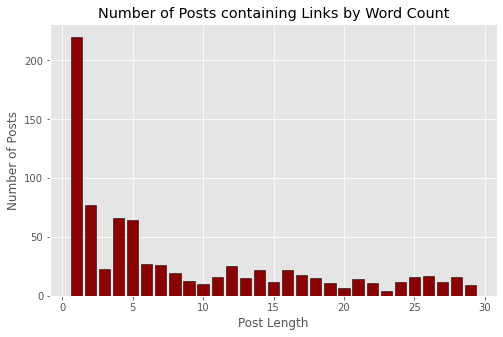

In [9]:
link_count = []

for i in range(1, 30):
    link_count.append(posts[(posts['post_wc'] == i) & 
                            (posts['selftext'].str.contains('http'))]['selftext'].shape[0])
    
plt.figure(figsize=(8,5))
style.use('ggplot')
plt.bar(x=range(1, 30), height=link_count, color='darkred', ec='black')
plt.xlabel('Post Length')
plt.ylabel('Number of Posts')
plt.title('Number of Posts containing Links by Word Count');

Seems like the number of posts containing links drops off when the word count is above 5, so let's focus on only **posts with a word count above 5**

In [10]:
posts_over_5_words = posts.copy()[posts['post_wc'] > 5] 

What's the distribution of post word count when the post is **over 5 words long**?

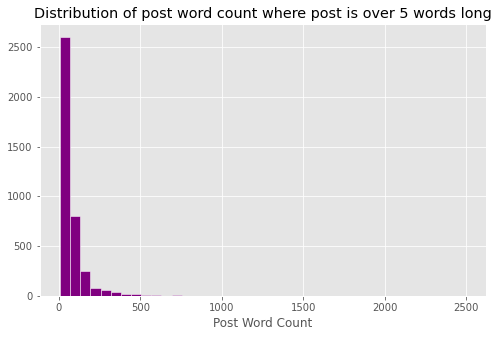

In [11]:
plt.figure(figsize=(8,5))
posts_over_5_words['post_wc'].hist(bins=40, ec='white', color='purple')
plt.title('Distribution of post word count where post is over 5 words long')
plt.xlabel('Post Word Count');

### What is the median word count per category?

In [12]:
posts_over_5_words.groupby('subreddit').median()['post_wc'] # Distribution is skewed right, so we're using median here as a measure of center

subreddit
poppunkers    44.0
punk          49.0
Name: post_wc, dtype: float64

In [13]:
posts_over_5_words.groupby('subreddit').count()['post_wc'] # We've still got over 1000 posts from each subreddit after removing posts with less than 5 words. Let's keep going!

subreddit
poppunkers    1916
punk          1961
Name: post_wc, dtype: int64

### Now I want to see who the 'Power Users' are, and whether there are any bots in the subreddits

In [14]:
posts_over_5_words['author'].value_counts()

AutoModerator        51
Psycho697186         47
Char_97              35
Neon_Dreamer_1997    24
shwaz499             18
                     ..
kaseyunread           1
Satana6               1
imbabie666            1
HolyRicardoiGuess     1
alpsman321            1
Name: author, Length: 2737, dtype: int64

I assume AutoModerator is not a person, but is--infact--an automated moderator. Let's make sure:

In [15]:
automod_author = posts_over_5_words['author'] == 'AutoModerator'

In [16]:
posts_over_5_words[automod_author]['selftext'].head()

63     What've you been listening to this week /r/pun...
84     Here you'll be able to discuss things that are...
170    What've you been listening to this week /r/pun...
206    Here you'll be able to discuss things that are...
290    What've you been listening to this week /r/pun...
Name: selftext, dtype: object

Confirmed! It's a bot. Let's get rid of the bot.

In [17]:
posts_over_5_words = posts_over_5_words.loc[~automod_author, :]

### How many unique users are there in each of the subreddits?

In [18]:
punk_sr = posts_over_5_words['subreddit'] == 'punk'

In [19]:
pop_punk_sr = posts_over_5_words['subreddit'] == 'poppunkers'

In [20]:
len(posts_over_5_words[punk_sr]['author'].unique())

1481

In [21]:
len(posts_over_5_words[pop_punk_sr]['author'].unique())

1297

`/r/poppunkers` has less unique users than `/r/punk`, this makes sense because the `punk` subreddit has more overall users.

In [ ]:
posts_over_5_words.to_csv('./data/reddit_clean.csv', index=False)